# Classwork 6 

In [1]:
# %load ../utils/imports.py
%matplotlib inline

import numpy as np
import pandas as pd

from utils import *
from utils.styles import *

In [2]:
# %load ../utils/plotting.py
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf

init_notebook_mode()
cf.go_offline()


Work through the following datasets, determining best fits for each data set (predictor value/y value in parens). To better evaluate or improve this process, try including:

* Increase the number of training points N. This might give us a training set with more coverage, and lead to greater accuracy.
* Increase the degree d of the polynomial. This might allow us to more closely fit the training data, and lead to a better result
* Add more features. If we were to, for example, perform a linear regression using x, x√, x−1, or other functions, we might hit on a functional form which can better be mapped to the value of y.

In [4]:
import statsmodels.api as sm

%matplotlib inline

DATA_DIR = '../data/'

## Predicting stopping distance

In [5]:
# Load the data
df = pd.read_csv(DATA_DIR + 'cars1920.csv')

In [6]:
# explore the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
speed    50 non-null int64
dist     50 non-null int64
dtypes: int64(2)
memory usage: 872.0 bytes


In [7]:
# explore the types of relationship you should model for, linear?
df.iplot(x="speed", y='dist', mode='markers', bestfit=True, shape='spline')

/home/io/.tools/anaconda/envs/dsx/lib/python2.7/site-packages/cufflinks/plotlytools.py:164: FutureWarning:

The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html



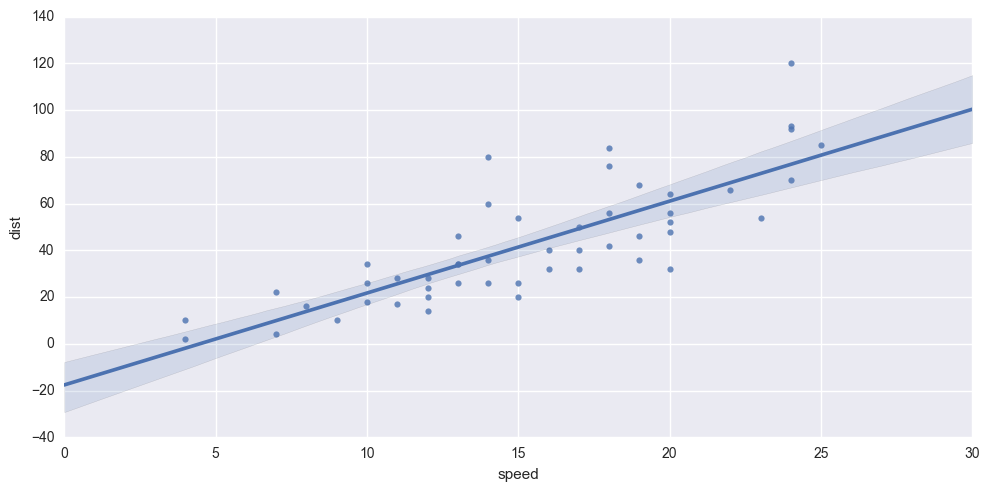

In [8]:
sns.lmplot("speed", "dist", df, order=1, aspect=2);

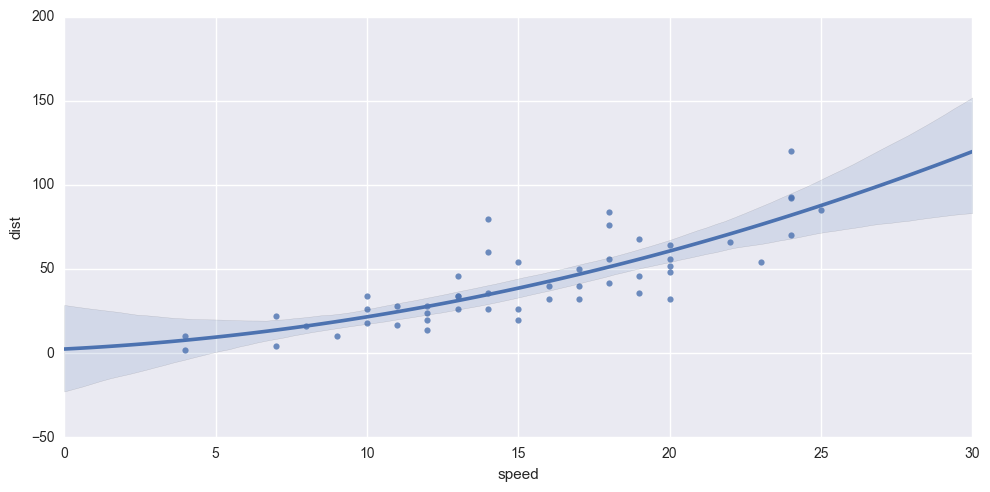

In [10]:
# explore the types of relationship you should model for, second order polynomial?
sns.lmplot("speed", "dist", df, order=2, aspect=2);

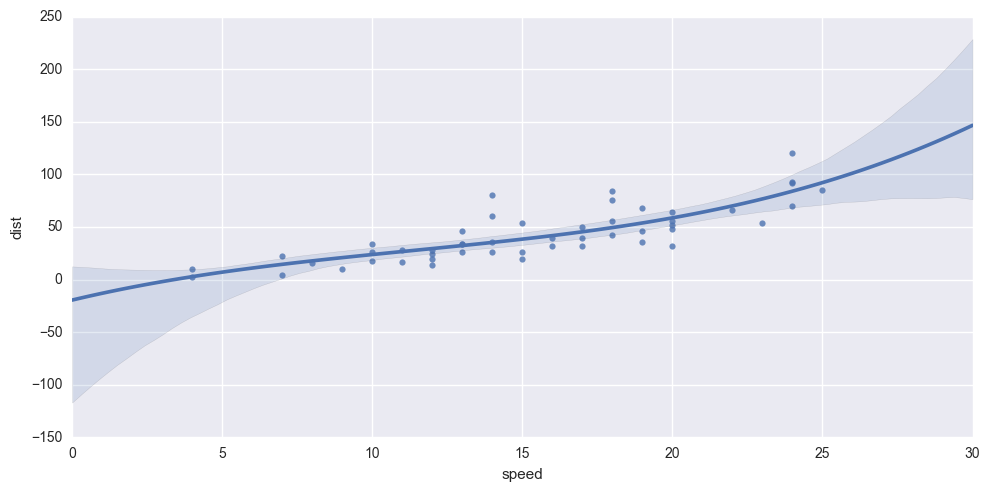

In [11]:
# explore the types of relationship you should model for, third order polynomial?
sns.lmplot("speed", "dist", df, order=3, aspect=2);

Since it is not strictly a linear relationship, we are going to use polynomial features. 
But there are two problems with this.

In [13]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures

X = [[i] for i in df.speed.values]
y = df.dist


scores = []
for model in [Ridge, Lasso]:
    for j in [0.1,0.5,1,2,5,10,20,100]: # ALPHA
        for i in range(1,6):            # POLY
            est = model(alpha=j)
            poly = PolynomialFeatures(i)
            X_poly = poly.fit_transform(X)
            est.fit(X_poly,y)
            scores.append((model.__name__, j, i, est.score(X_poly,y)))
            
df_scores = pd.DataFrame(scores, columns=['model','alpha','poly','score'])

In [16]:
df_scores.ix[df_scores.score.idxmax()]

model       Ridge
alpha         0.1
poly            5
score    0.684565
Name: 4, dtype: object

### Orthogonal Polynomials - Advanced

First, we can generate highly correlated regressors by taking powers of `x`, leading to noisy parameter estimates. The input `x` are evenly space numbers on the interval `[0, 1]`. So `x` and $x^2$ are going to have a correlation over `95%`. Similar with $x^2$ and $x^3$. The solution to this is to use orthogonalized polynomial functions: tranformations of `x` that, when summed, result in polynomial functions, but are orthogonal (therefore uncorrelated) with each other.

Luckily, we can easily calculate these transformations using patsy. The `C(x, Poly)` transform computes orthonormal polynomial functions of `x`, then we’ll extract out various orders of the polynomial. So `Xpoly[:, :2]` selects out the `0th` and 1st order functions, then when summed will give us a first order polynomial (i.e. linear). Similarly `Xpoly[: :4]` gives us the 0th through 3rd order functions, which sum up to a cubic polynomial.

Math review : [Orthogonal Polynomials](http://mathoverflow.net/questions/38864/visualizing-orthogonal-polynomials)

In [17]:
from patsy import dmatrix

In [19]:
speed = df.speed.values
dist = df.dist.values
y = dist

speed_poly = dmatrix('C(speed, Poly)')

In [22]:
# Only Speed
speed_poly1 = dmatrix('speed', df)

# Only Speed^2
speed_sq = dmatrix('np.power(speed,2)', df)

# Speed + Speed^2
speed_poly2 = dmatrix('speed + np.power(speed,2)')

# Orthoganal Polynnomials for ^3, ^5 and ^25
speed_poly3 = speed_poly[:, :4]
speed_poly5 = speed_poly[:, :6]
speed_poly25 = speed_poly[:, :26]

In [24]:
Xs = [speed_poly1, speed_sq, speed_poly2, speed_poly3, speed_poly5, speed_poly25]

In [ ]:
speed_poly2[:5]

In [25]:
# Let's see how closely they are correlated.
pd.DataFrame(np.corrcoef(speed_poly25)).iplot(kind='heatmap',colorscale='spectral')

### Overfitting

The problem we encounter now is how to choose what order polynomial to fit to the data. Any data can be fit well (i.e. have a high $R^2$) if we use a high enough order polynomial. But we will start to over-fit our data; capturing noise specific to our sample, leading to poor predictions on new data. The graph below shows the fits to the data of a straight line, a 3rd-order polynomial, a 5th-order polynomial, and a 25th-order polynomial.

In [26]:
speed_poly1_pred = sm.OLS(y, speed_poly1).fit().predict()
speed_sq_pred = sm.OLS(y, speed_sq).fit().predict()
speed_poly2_pred = sm.OLS(y, speed_poly2).fit().predict()
speed_poly3_pred = sm.OLS(y, speed_poly3).fit().predict()
speed_poly5_pred = sm.OLS(y, speed_poly5).fit().predict()
speed_poly25_pred = sm.OLS(y, speed_poly25).fit().predict()

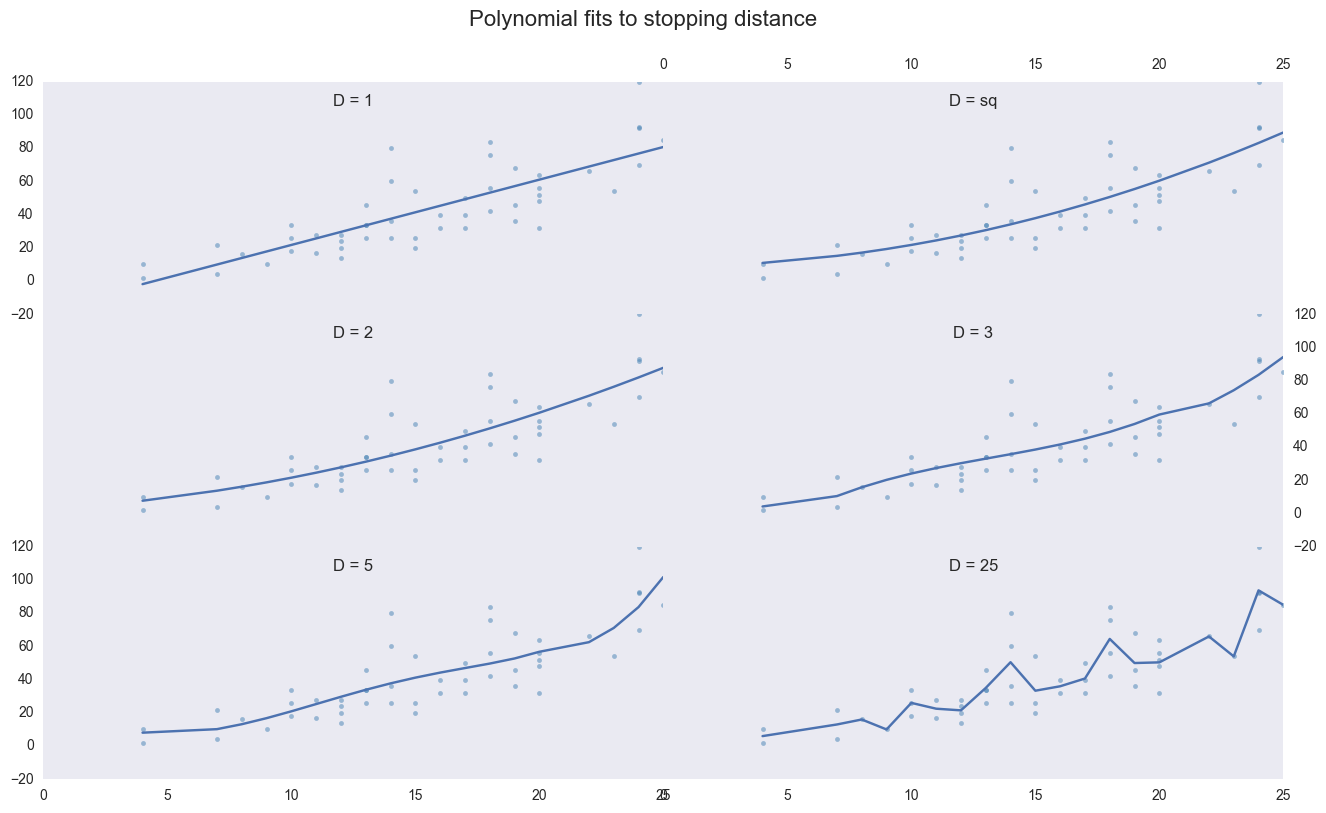

In [27]:
import matplotlib.pyplot as plt

plt.figure()

fig, ax = plt.subplots(3, 2, sharex = True, sharey = True, figsize=(16,9))
fig.subplots_adjust(hspace = 0.0, wspace = 0.0)
fig.suptitle('Polynomial fits to stopping distance', fontsize = 16.0)

# Iterate through panels (a), model predictions (p), and the polynomial 
# degree of the model (d). Plot the data, the predictions, and label
# the graph to indicate the degree used.
preds = [speed_poly1_pred, speed_sq_pred, speed_poly2_pred,
         speed_poly3_pred, speed_poly5_pred, speed_poly25_pred]
orders = ['1', 'sq', '2', '3', '5', '25']

for a, p, d in zip(ax.ravel(), preds, orders):
    a.plot(df.speed.values, df.dist.values, '.', color = 'steelblue', alpha = 0.5)
    a.plot(df.speed.values, p)
    a.text(.5, .95, 'D = ' + d, fontsize = 12,
           verticalalignment = 'top',
           horizontalalignment = 'center',
           transform = a.transAxes)
    a.grid()
    
# Alternate axes that have tick labels to avoid overlap.
plt.setp(fig.axes[2].get_yaxis().get_ticklabels(), visible = False)
plt.setp(fig.axes[3].get_yaxis(), ticks_position = 'right')   
plt.setp(fig.axes[1].get_xaxis(), ticks_position = 'top')
plt.setp(fig.axes[3].get_xaxis().get_ticklabels(), visible = False);

 Notice how the last fit gives us all kinds of degrees of freedom to capture specific datapoints, and the excessive “wiggles” look like we’re fitting to noise.

### Scoring your models

In [28]:
for order, X in zip(orders, Xs):
    print "%s : %.03f" % (order, sm.OLS(y, X).fit().rsquared)

1 : 0.651
sq : 0.666
2 : 0.667
3 : 0.672
5 : 0.680
25 : 0.792


Without cross-validation - which we'll be covering soon, it would appear that the `sq` model is preferred as that provides us with a smooth line, 

In [29]:
# The same with our SciKit Learn Models

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures

X = [[i] for i in df.speed.values]
y = df.dist

scores = []
for model in [Ridge, Lasso]:
    for j in [0.1,0.5,1,2,5,10,20,100]: # ALPHA
        for i in range(1,14):           # POLY
            est = model(alpha=j)
            poly = PolynomialFeatures(i)
            X_poly = poly.fit_transform(X)
            est.fit(X_poly,y)
            scores.append((model.__name__, j, i, est.score(X_poly,y)))
            
df_scores = pd.DataFrame(scores, columns=['model','alpha','poly','score'])

title = '<b>R-Squared for Linear Regression</b><br>With L1 and L2 Regularisation'
yTitle = 'R-Squared'
xTitle = 'Number of Polynominals'

df_scores.groupby(['model','poly']).max().score.unstack(0).iplot(title=title,yTitle=yTitle,xTitle=xTitle)

Now let's try this with cross-validation

In [51]:
from sklearn.cross_validation import cross_val_score

scores = []
for model in [Ridge, Lasso]:
    for j in [0.1,0.5,1,2,5,10,20,100]: # ALPHA
        for i in range(1,6):           # POLY
            est = model(alpha=j)
            poly = PolynomialFeatures(i)
            X_poly = poly.fit_transform(X)
            
            scores.append((model.__name__, j, i, cross_val_score(est, X_poly, y).mean()))
            
df_scores = pd.DataFrame(scores, columns=['model','alpha','poly','score'])

title = '<b>R-Squared for Linear Regression</b><br>With L1 and L2 Regularisation'
yTitle = 'R-Squared'
xTitle = 'Number of Polynominals'

df_scores.groupby(['model','poly']).max().score.unstack(0).iplot(title=title,yTitle=yTitle,xTitle=xTitle)

## Predicting City and Highway MPG.

In [53]:
# Load the data
import pandas as pd

DATA_DIR = '../data/'

df = pd.read_csv(DATA_DIR + 'cars93.csv')

### Inspect the Data

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 27 columns):
Manufacturer          93 non-null object
Model                 93 non-null object
Type                  93 non-null object
Min.Price             93 non-null float64
Price                 93 non-null float64
Max.Price             93 non-null float64
MPG.city              93 non-null int64
MPG.highway           93 non-null int64
AirBags               93 non-null object
DriveTrain            93 non-null object
Cylinders             93 non-null object
EngineSize            93 non-null float64
Horsepower            93 non-null int64
RPM                   93 non-null int64
Rev.per.mile          93 non-null int64
Man.trans.avail       93 non-null object
Fuel.tank.capacity    93 non-null float64
Passengers            93 non-null int64
Length                93 non-null int64
Wheelbase             93 non-null int64
Width                 93 non-null int64
Turn.circle           93 non-null int64


In [55]:
df.Cylinders.value_counts()

4         49
6         31
8          7
3          3
5          2
rotary     1
Name: Cylinders, dtype: int64

In [56]:
df.Make.head()

0    Acura Integra
1     Acura Legend
2          Audi 90
3         Audi 100
4         BMW 535i
Name: Make, dtype: object

In [57]:
range(5)

[0, 1, 2, 3, 4]

In [58]:
pd.get_dummies(df.Manufacturer).head()

Acura  Audi  BMW  Buick  Cadillac  Chevrolet  Chrylser  Chrysler  Dodge  \
0    1.0   0.0  0.0    0.0       0.0        0.0       0.0       0.0    0.0   
1    1.0   0.0  0.0    0.0       0.0        0.0       0.0       0.0    0.0   
2    0.0   1.0  0.0    0.0       0.0        0.0       0.0       0.0    0.0   
3    0.0   1.0  0.0    0.0       0.0        0.0       0.0       0.0    0.0   
4    0.0   0.0  1.0    0.0       0.0        0.0       0.0       0.0    0.0   

   Eagle  ...    Oldsmobile  Plymouth  Pontiac  Saab  Saturn  Subaru  Suzuki  \
0    0.0  ...           0.0       0.0      0.0   0.0     0.0     0.0     0.0   
1    0.0  ...           0.0       0.0      0.0   0.0     0.0     0.0     0.0   
2    0.0  ...           0.0       0.0      0.0   0.0     0.0     0.0     0.0   
3    0.0  ...           0.0       0.0      0.0   0.0     0.0     0.0     0.0   
4    0.0  ...           0.0       0.0      0.0   0.0     0.0     0.0     0.0   

   Toyota  Volkswagen  Volvo  
0     0.0         0.0    0.0  
1     0.0         0.0    0.0  
2     0.0         0.0    0.0  
3     0.0         0.0    0.0  
4     0.0         0.0    0.0  

[5 rows x 32 columns]

### Inspecting Datatypes

In [59]:
# Check if any of the columns marked as 'object' shouldn't be int or float instead
objs = df.columns[df.dtypes == object]
df[objs]

Manufacturer          Model     Type             AirBags DriveTrain  \
0         Acura        Integra    Small                None      Front   
1         Acura         Legend  Midsize  Driver & Passenger      Front   
2          Audi             90  Compact         Driver only      Front   
3          Audi            100  Midsize  Driver & Passenger      Front   
4           BMW           535i  Midsize         Driver only       Rear   
5         Buick        Century  Midsize         Driver only      Front   
6         Buick        LeSabre    Large         Driver only      Front   
7         Buick     Roadmaster    Large         Driver only       Rear   
8         Buick        Riviera  Midsize         Driver only      Front   
9      Cadillac        DeVille    Large         Driver only      Front   
10     Cadillac        Seville  Midsize  Driver & Passenger      Front   
11    Chevrolet       Cavalier  Compact                None      Front   
12    Chevrolet        Corsica  Compact         Driver only      Front   
13    Chevrolet         Camaro   Sporty  Driver & Passenger       Rear   
14    Chevrolet         Lumina  Midsize                None      Front   
15    Chevrolet     Lumina_APV      Van                None      Front   
16    Chevrolet          Astro      Van                None        4WD   
17    Chevrolet        Caprice    Large         Driver only       Rear   
18    Chevrolet       Corvette   Sporty         Driver only       Rear   
19     Chrylser       Concorde    Large  Driver & Passenger      Front   
20     Chrysler        LeBaron  Compact  Driver & Passenger      Front   
21     Chrysler       Imperial    Large         Driver only      Front   
22        Dodge           Colt    Small                None      Front   
23        Dodge         Shadow    Small         Driver only      Front   
24        Dodge         Spirit  Compact         Driver only      Front   
25        Dodge        Caravan      Van         Driver only        4WD   
26        Dodge        Dynasty  Midsize         Driver only      Front   
27        Dodge        Stealth   Sporty         Driver only        4WD   
28        Eagle         Summit    Small                None      Front   
29        Eagle         Vision    Large  Driver & Passenger      Front   
..          ...            ...      ...                 ...        ...   
63       Nissan         Sentra    Small         Driver only      Front   
64       Nissan         Altima  Compact         Driver only      Front   
65       Nissan          Quest      Van                None      Front   
66       Nissan         Maxima  Midsize         Driver only      Front   
67   Oldsmobile        Achieva  Compact                None      Front   
68   Oldsmobile  Cutlass_Ciera  Midsize         Driver only      Front   
69   Oldsmobile     Silhouette      Van                None      Front   
70   Oldsmobile   Eighty-Eight    Large         Driver only      Front   
71     Plymouth          Laser   Sporty                None        4WD   
72      Pontiac         LeMans    Small                None      Front   
73      Pontiac        Sunbird  Compact                None      Front   
74      Pontiac       Firebird   Sporty  Driver & Passenger       Rear   
75      Pontiac     Grand_Prix  Midsize                None      Front   
76      Pontiac     Bonneville    Large  Driver & Passenger      Front   
77         Saab            900  Compact         Driver only      Front   
78       Saturn             SL    Small         Driver only      Front   
79       Subaru          Justy    Small                None        4WD   
80       Subaru         Loyale    Small                None        4WD   
81       Subaru         Legacy  Compact         Driver only        4WD   
82       Suzuki          Swift    Small                None      Front   
83       Toyota         Tercel    Small         Driver only      Front   
84       Toyota         Celica   Sporty         Driver only      Front   
85     

In [60]:
df.Make

0                Acura Integra
1                 Acura Legend
2                      Audi 90
3                     Audi 100
4                     BMW 535i
5                Buick Century
6                Buick LeSabre
7             Buick Roadmaster
8                Buick Riviera
9             Cadillac DeVille
10            Cadillac Seville
11          Chevrolet Cavalier
12           Chevrolet Corsica
13            Chevrolet Camaro
14            Chevrolet Lumina
15        Chevrolet Lumina_APV
16             Chevrolet Astro
17           Chevrolet Caprice
18          Chevrolet Corvette
19           Chrylser Concorde
20            Chrysler LeBaron
21           Chrysler Imperial
22                  Dodge Colt
23                Dodge Shadow
24                Dodge Spirit
25               Dodge Caravan
26               Dodge Dynasty
27               Dodge Stealth
28                Eagle Summit
29                Eagle Vision
                ...           
63               Nissan Sentra
64      

In [61]:
df[objs[:2]]

Manufacturer          Model
0         Acura        Integra
1         Acura         Legend
2          Audi             90
3          Audi            100
4           BMW           535i
5         Buick        Century
6         Buick        LeSabre
7         Buick     Roadmaster
8         Buick        Riviera
9      Cadillac        DeVille
10     Cadillac        Seville
11    Chevrolet       Cavalier
12    Chevrolet        Corsica
13    Chevrolet         Camaro
14    Chevrolet         Lumina
15    Chevrolet     Lumina_APV
16    Chevrolet          Astro
17    Chevrolet        Caprice
18    Chevrolet       Corvette
19     Chrylser       Concorde
20     Chrysler        LeBaron
21     Chrysler       Imperial
22        Dodge           Colt
23        Dodge         Shadow
24        Dodge         Spirit
25        Dodge        Caravan
26        Dodge        Dynasty
27        Dodge        Stealth
28        Eagle         Summit
29        Eagle         Vision
..          ...            ...
63       Nissan         Sentra
64       Nissan         Altima
65       Nissan          Quest
66       Nissan         Maxima
67   Oldsmobile        Achieva
68   Oldsmobile  Cutlass_Ciera
69   Oldsmobile     Silhouette
70   Oldsmobile   Eighty-Eight
71     Plymouth          Laser
72      Pontiac         LeMans
73      Pontiac        Sunbird
74      Pontiac       Firebird
75      Pontiac     Grand_Prix
76      Pontiac     Bonneville
77         Saab            900
78       Saturn             SL
79       Subaru          Justy
80       Subaru         Loyale
81       Subaru         Legacy
82       Suzuki          Swift
83       Toyota         Tercel
84       Toyota         Celica
85       Toyota          Camry
86       Toyota         Previa
87   Volkswagen            Fox
88   Volkswagen        Eurovan
89   Volkswagen         Passat
90   Volkswagen        Corrado
91        Volvo            240
92        Volvo            850

[93 rows x 2 columns]

Yuhk - full stops in the column names, let's get rid of those first.

In [62]:
df.columns = [col.replace('.','') for col in df.columns]

In [63]:
# Hmmm why is the cylinder not an integer dtype?
df.Cylinders

0     4
1     6
2     6
3     6
4     4
5     4
6     6
7     6
8     6
9     8
10    8
11    4
12    4
13    6
14    4
15    6
16    6
17    8
18    8
19    6
20    4
21    6
22    4
23    4
24    4
25    6
26    4
27    6
28    4
29    6
     ..
63    4
64    4
65    6
66    6
67    4
68    4
69    6
70    6
71    4
72    4
73    4
74    6
75    6
76    6
77    4
78    4
79    3
80    4
81    4
82    3
83    4
84    4
85    4
86    4
87    4
88    5
89    4
90    6
91    4
92    5
Name: Cylinders, dtype: object

In [64]:
# Let's try coercing it into an int datatype
try:
    [int(v) for v in df.Cylinders if type(v)]
except ValueError as e:
    print(e)

invalid literal for int() with base 10: 'rotary'


In [65]:
# Ah, there's a row with a peculiar value
df[df.Cylinders == 'rotary']

Manufacturer Model    Type  MinPrice  Price  MaxPrice  MPGcity  MPGhighway  \
56        Mazda  RX-7  Sporty      32.5   32.5      32.5       17          25   

        AirBags DriveTrain     ...     Passengers  Length  Wheelbase  Width  \
56  Driver only       Rear     ...              2     169         96     69   

    Turncircle Rearseatroom  Luggageroom  Weight   Origin        Make  
56          37          NaN          NaN    2895  non-USA  Mazda RX-7  

[1 rows x 27 columns]

In [66]:
# Let's set the number of cylinders to 0
df.loc[df.Cylinders == 'rotary', 'Cylinders'] = 0

In [67]:
# Change the Cylinder datatype
df.Cylinders = df.Cylinders.astype(int)
df.Cylinders.dtype

dtype('int64')

### Handling Missing Values

In [68]:
# Check for missing values

# Create a helper function to catch columns with any missing values
# Logic : Check if there are any missing values, and sum them. True
# counts as '1' so that's why this elegant solution works! 
is_null = lambda col: sum(pd.isnull(df[col]))

# Logic : return (column name, missing value count) for each of the
# columns in the dataframe, _if_ there are any missing values
missing_values = [(col,is_null(col)) for col in df if is_null(col)]
missing_values

[('Rearseatroom', 2), ('Luggageroom', 11)]

Two columns have missing values, let's take a closer look at the data and figure out why that's the case.

#### Rear.seat.room

In [69]:
select = missing_values[0][0]
df[df[select].isnull()]

Manufacturer     Model    Type  MinPrice  Price  MaxPrice  MPGcity  \
18    Chevrolet  Corvette  Sporty      34.6   38.0      41.5       17   
56        Mazda      RX-7  Sporty      32.5   32.5      32.5       17   

    MPGhighway      AirBags DriveTrain         ...          Passengers  \
18          25  Driver only       Rear         ...                   2   
56          25  Driver only       Rear         ...                   2   

    Length  Wheelbase  Width  Turncircle Rearseatroom  Luggageroom  Weight  \
18     179         96     74          43          NaN          NaN    3380   
56     169         96     69          37          NaN          NaN    2895   

     Origin                Make  
18      USA  Chevrolet Corvette  
56  non-USA          Mazda RX-7  

[2 rows x 27 columns]

OK - so they are both sports cars. But let's sort by `Rear.seat.room` and see whether it's just that there _is_ no rear seat space, or whether the data is truly missing.

In [70]:
df.sort_values('Rearseatroom')[['Manufacturer','Model','Type','Rearseatroom']]

Manufacturer           Model     Type  Rearseatroom
59        Mercury           Capri   Sporty          19.0
27          Dodge         Stealth   Sporty          20.0
34           Ford           Probe   Sporty          23.0
84         Toyota          Celica   Sporty          23.0
79         Subaru           Justy    Small          23.5
40          Honda         Prelude   Sporty          23.5
45        Hyundai          Scoupe   Sporty          23.5
83         Toyota          Tercel    Small          24.0
33           Ford         Mustang   Sporty          24.0
39            Geo           Storm   Sporty          24.5
71       Plymouth           Laser   Sporty          24.5
73        Pontiac         Sunbird  Compact          25.0
74        Pontiac        Firebird   Sporty          25.0
13      Chevrolet          Camaro   Sporty          25.0
11      Chevrolet        Cavalier  Compact          25.0
49          Lexus           SC300  Midsize          25.0
72        Pontiac          LeMans    Small          25.5
61     Mitsubishi          Mirage    Small          26.0
43        Hyundai           Excel    Small          26.0
87     Volkswagen             Fox    Small          26.0
63         Nissan          Sentra    Small          26.0
90     Volkswagen         Corrado   Sporty          26.0
30           Ford         Festiva    Small          26.0
12      Chevrolet         Corsica  Compact          26.0
57  Mercedes-Benz            190E  Compact          26.0
53          Mazda         Protege    Small          26.5
28          Eagle          Summit    Small          26.5
0           Acura         Integra    Small          26.5
23          Dodge          Shadow    Small          26.5
25          Dodge         Caravan      Van          26.5
..            ...             ...      ...           ...
91          Volvo             240  Compact          29.5
17      Chevrolet         Caprice    Large          29.5
92          Volvo             850  Midsize          30.0
50        Lincoln     Continental  Midsize          30.0
1           Acura          Legend  Midsize          30.0
37           Ford  Crown_Victoria    Large          30.0
35           Ford        Aerostar      Van          30.0
29          Eagle          Vision    Large          30.0
69     Oldsmobile      Silhouette      Van          30.5
26          Dodge         Dynasty  Midsize          30.5
24          Dodge          Spirit  Compact          30.5
76        Pontiac      Bonneville    Large          30.5
20       Chrysler         LeBaron  Compact          30.5
6           Buick         LeSabre    Large          30.5
7           Buick      Roadmaster    Large          30.5
15      Chevrolet      Lumina_APV      Van          30.5
3            Audi             100  Midsize          31.0
46        Hyundai          Sonata  Midsize          31.0
19       Chrylser        Concorde    Large          31.0
10       Cadillac         Seville  Midsize          31.0
51        Lincoln        Town_Car    Large          31.5
89     Volkswagen          Passat  Compact          31.5
70     Oldsmobile    Eighty-Eight    Large          31.5
16      Chevrolet           Astro      Van          33.5
88     Volkswagen         Eurovan      Van          34.0
9        Cadillac         DeVille    Large          35.0
86         Toyota          Previa      Van          35.0
21       Chrysler        Imperial    Large          36.0
18      Chevrolet        Corvette   Sporty           NaN
56          Mazda            RX-7   Sporty           NaN

[93 rows x 4 columns]

There are no cars where the `Rear.seat.room` is set to zero, so after a bit of Googling, you'd find that indeed these two cars don't allow for passengers in the back, so we can set these values to zero.

In [71]:
crit = df['Rearseatroom'].isnull()
df.loc[crit, 'Rearseatroom'] = 0

#### Luggage.room

Now let's inspect the missing values for `Luggage.room`

In [72]:
select = missing_values[1][0]
df[df[select].isnull()]

Manufacturer       Model    Type  MinPrice  Price  MaxPrice  MPGcity  \
15    Chevrolet  Lumina_APV     Van      14.7   16.3      18.0       18   
16    Chevrolet       Astro     Van      14.7   16.6      18.6       15   
18    Chevrolet    Corvette  Sporty      34.6   38.0      41.5       17   
25        Dodge     Caravan     Van      13.6   19.0      24.4       17   
35         Ford    Aerostar     Van      14.5   19.9      25.3       15   
55        Mazda         MPV     Van      16.6   19.1      21.7       18   
56        Mazda        RX-7  Sporty      32.5   32.5      32.5       17   
65       Nissan       Quest     Van      16.7   19.1      21.5       17   
69   Oldsmobile  Silhouette     Van      19.5   19.5      19.5       18   
86       Toyota      Previa     Van      18.9   22.7      26.6       18   
88   Volkswagen     Eurovan     Van      16.6   19.7      22.7       17   

    MPGhighway      AirBags DriveTrain          ...            Passengers  \
15          23         None      Front          ...                     7   
16          20         None        4WD          ...                     8   
18          25  Driver only       Rear          ...                     2   
25          21  Driver only        4WD          ...                     7   
35          20  Driver only        4WD          ...                     7   
55          24         None        4WD          ...                     7   
56          25  Driver only       Rear          ...                     2   
65          23         None      Front          ...                     7   
69          23         None      Front          ...                     7   
86          22  Driver only        4WD          ...                     7   
88          21         None      Front          ...                     7   

    Length  Wheelbase  Width  Turncircle Rearseatroom  Luggageroom  Weight  \
15     178        110     74          44         30.5          NaN    3715   
16     194        111     78          42         33.5          NaN    4025   
18     179         96     74          43          0.0          NaN    3380   
25     175        112     72          42         26.5          NaN    3705   
35     176        119     72          45         30.0          NaN    3735   
55     190        110     72          39         27.5          NaN    3735   
56     169         96     69          37          0.0          NaN    2895   
65     190        112     74          41         27.0          NaN    4100   
69     194        110     74          44         30.5          NaN    3715   
86     187        113     71          41         35.0          NaN    3785   
88     187        115     72          38         34.0          NaN    3960   

     Origin                   Make  
15      USA   Chevrolet Lumina_APV  
16      USA        Chevrolet Astro  
18      USA     Chevrolet Corvette  
25      USA          Dodge Caravan  
35      USA          Ford Aerostar  
55  non-USA              Mazda MPV  
56  non-USA             Mazda RX-7  
65  non-USA           Nissan Quest  
69      USA  Oldsmobile Silhouette  
86  non-USA          Toyota Previa  
88  non-USA     Volkswagen Eurovan  

[11 rows x 27 columns]

Lot's of vans, and the two sports cars we just dealt with for missing Rear.seat.room values! Let's see how Vans 
are dealt with.

In [73]:
df[df.Type == 'Van']

Manufacturer       Model Type  MinPrice  Price  MaxPrice  MPGcity  \
15    Chevrolet  Lumina_APV  Van      14.7   16.3      18.0       18   
16    Chevrolet       Astro  Van      14.7   16.6      18.6       15   
25        Dodge     Caravan  Van      13.6   19.0      24.4       17   
35         Ford    Aerostar  Van      14.5   19.9      25.3       15   
55        Mazda         MPV  Van      16.6   19.1      21.7       18   
65       Nissan       Quest  Van      16.7   19.1      21.5       17   
69   Oldsmobile  Silhouette  Van      19.5   19.5      19.5       18   
86       Toyota      Previa  Van      18.9   22.7      26.6       18   
88   Volkswagen     Eurovan  Van      16.6   19.7      22.7       17   

    MPGhighway      AirBags DriveTrain          ...            Passengers  \
15          23         None      Front          ...                     7   
16          20         None        4WD          ...                     8   
25          21  Driver only        4WD          ...                     7   
35          20  Driver only        4WD          ...                     7   
55          24         None        4WD          ...                     7   
65          23         None      Front          ...                     7   
69          23         None      Front          ...                     7   
86          22  Driver only        4WD          ...                     7   
88          21         None      Front          ...                     7   

    Length  Wheelbase  Width  Turncircle Rearseatroom  Luggageroom  Weight  \
15     178        110     74          44         30.5          NaN    3715   
16     194        111     78          42         33.5          NaN    4025   
25     175        112     72          42         26.5          NaN    3705   
35     176        119     72          45         30.0          NaN    3735   
55     190        110     72          39         27.5          NaN    3735   
65     190        112     74          41         27.0          NaN    4100   
69     194        110     74          44         30.5          NaN    3715   
86     187        113     71          41         35.0          NaN    3785   
88     187        115     72          38         34.0          NaN    3960   

     Origin                   Make  
15      USA   Chevrolet Lumina_APV  
16      USA        Chevrolet Astro  
25      USA          Dodge Caravan  
35      USA          Ford Aerostar  
55  non-USA              Mazda MPV  
65  non-USA           Nissan Quest  
69      USA  Oldsmobile Silhouette  
86  non-USA          Toyota Previa  
88  non-USA     Volkswagen Eurovan  

[9 rows x 27 columns]

OK - turns out none of the vans are considered to have 'luggage room' , so let's also set ll these values to zero.

In [74]:
crit = df['Luggageroom'].isnull()
df.loc[crit, 'Luggageroom'] = 0

Sanity check to make sure we can move on now.

In [75]:
missing_values = [(col,is_null(col)) for col in df if is_null(col)]
len(missing_values)

0

### Split out design matrix and response vector

In [78]:
# Let's build a model for MPG.city
y = df['MPGcity']
# y = df['MPG.highway']

# Lazy selection of all numeric columns without MPG
X = df.select_dtypes(['int','float']).drop(['MPGcity','MPGhighway'],axis=1)
X.head()

MinPrice  Price  MaxPrice  Cylinders  EngineSize  Horsepower   RPM  \
0      12.9   15.9      18.8          4         1.8         140  6300   
1      29.2   33.9      38.7          6         3.2         200  5500   
2      25.9   29.1      32.3          6         2.8         172  5500   
3      30.8   37.7      44.6          6         2.8         172  5500   
4      23.7   30.0      36.2          4         3.5         208  5700   

   Revpermile  Fueltankcapacity  Passengers  Length  Wheelbase  Width  \
0        2890              13.2           5     177        102     68   
1        2335              18.0           5     195        115     71   
2        2280              16.9           5     180        102     67   
3        2535              21.1           6     193        106     70   
4        2545              21.1           4     186        109     69   

   Turncircle  Rearseatroom  Luggageroom  Weight  
0          37          26.5         11.0    2705  
1          38          30.0         15.0    3560  
2          37          28.0         14.0    3375  
3          37          31.0         17.0    3405  
4          39          27.0         13.0    3640

### Feature Selection

Is there a potential relationship between the predictors and the response variable?

In [80]:
from sklearn import feature_selection as fs

def f_regression_feature_selection(input, response):    
# use this against your feature matrix to determine p-values for
# each feature (we care about the second array it returns).
    return fs.univariate_selection.f_regression(input, response)    

#### ValueError?

If your attempt of running `f_regression_feature_selection` with a current `X` and `y` failed with the error:

```bash
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
```
this meant that you likely didn't properly clean out the missing values from your design matrix.

### Visual Exploration of Correlation

In [81]:
data = pd.DataFrame(X,y).reset_index()

/home/io/.tools/anaconda/envs/dsx/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



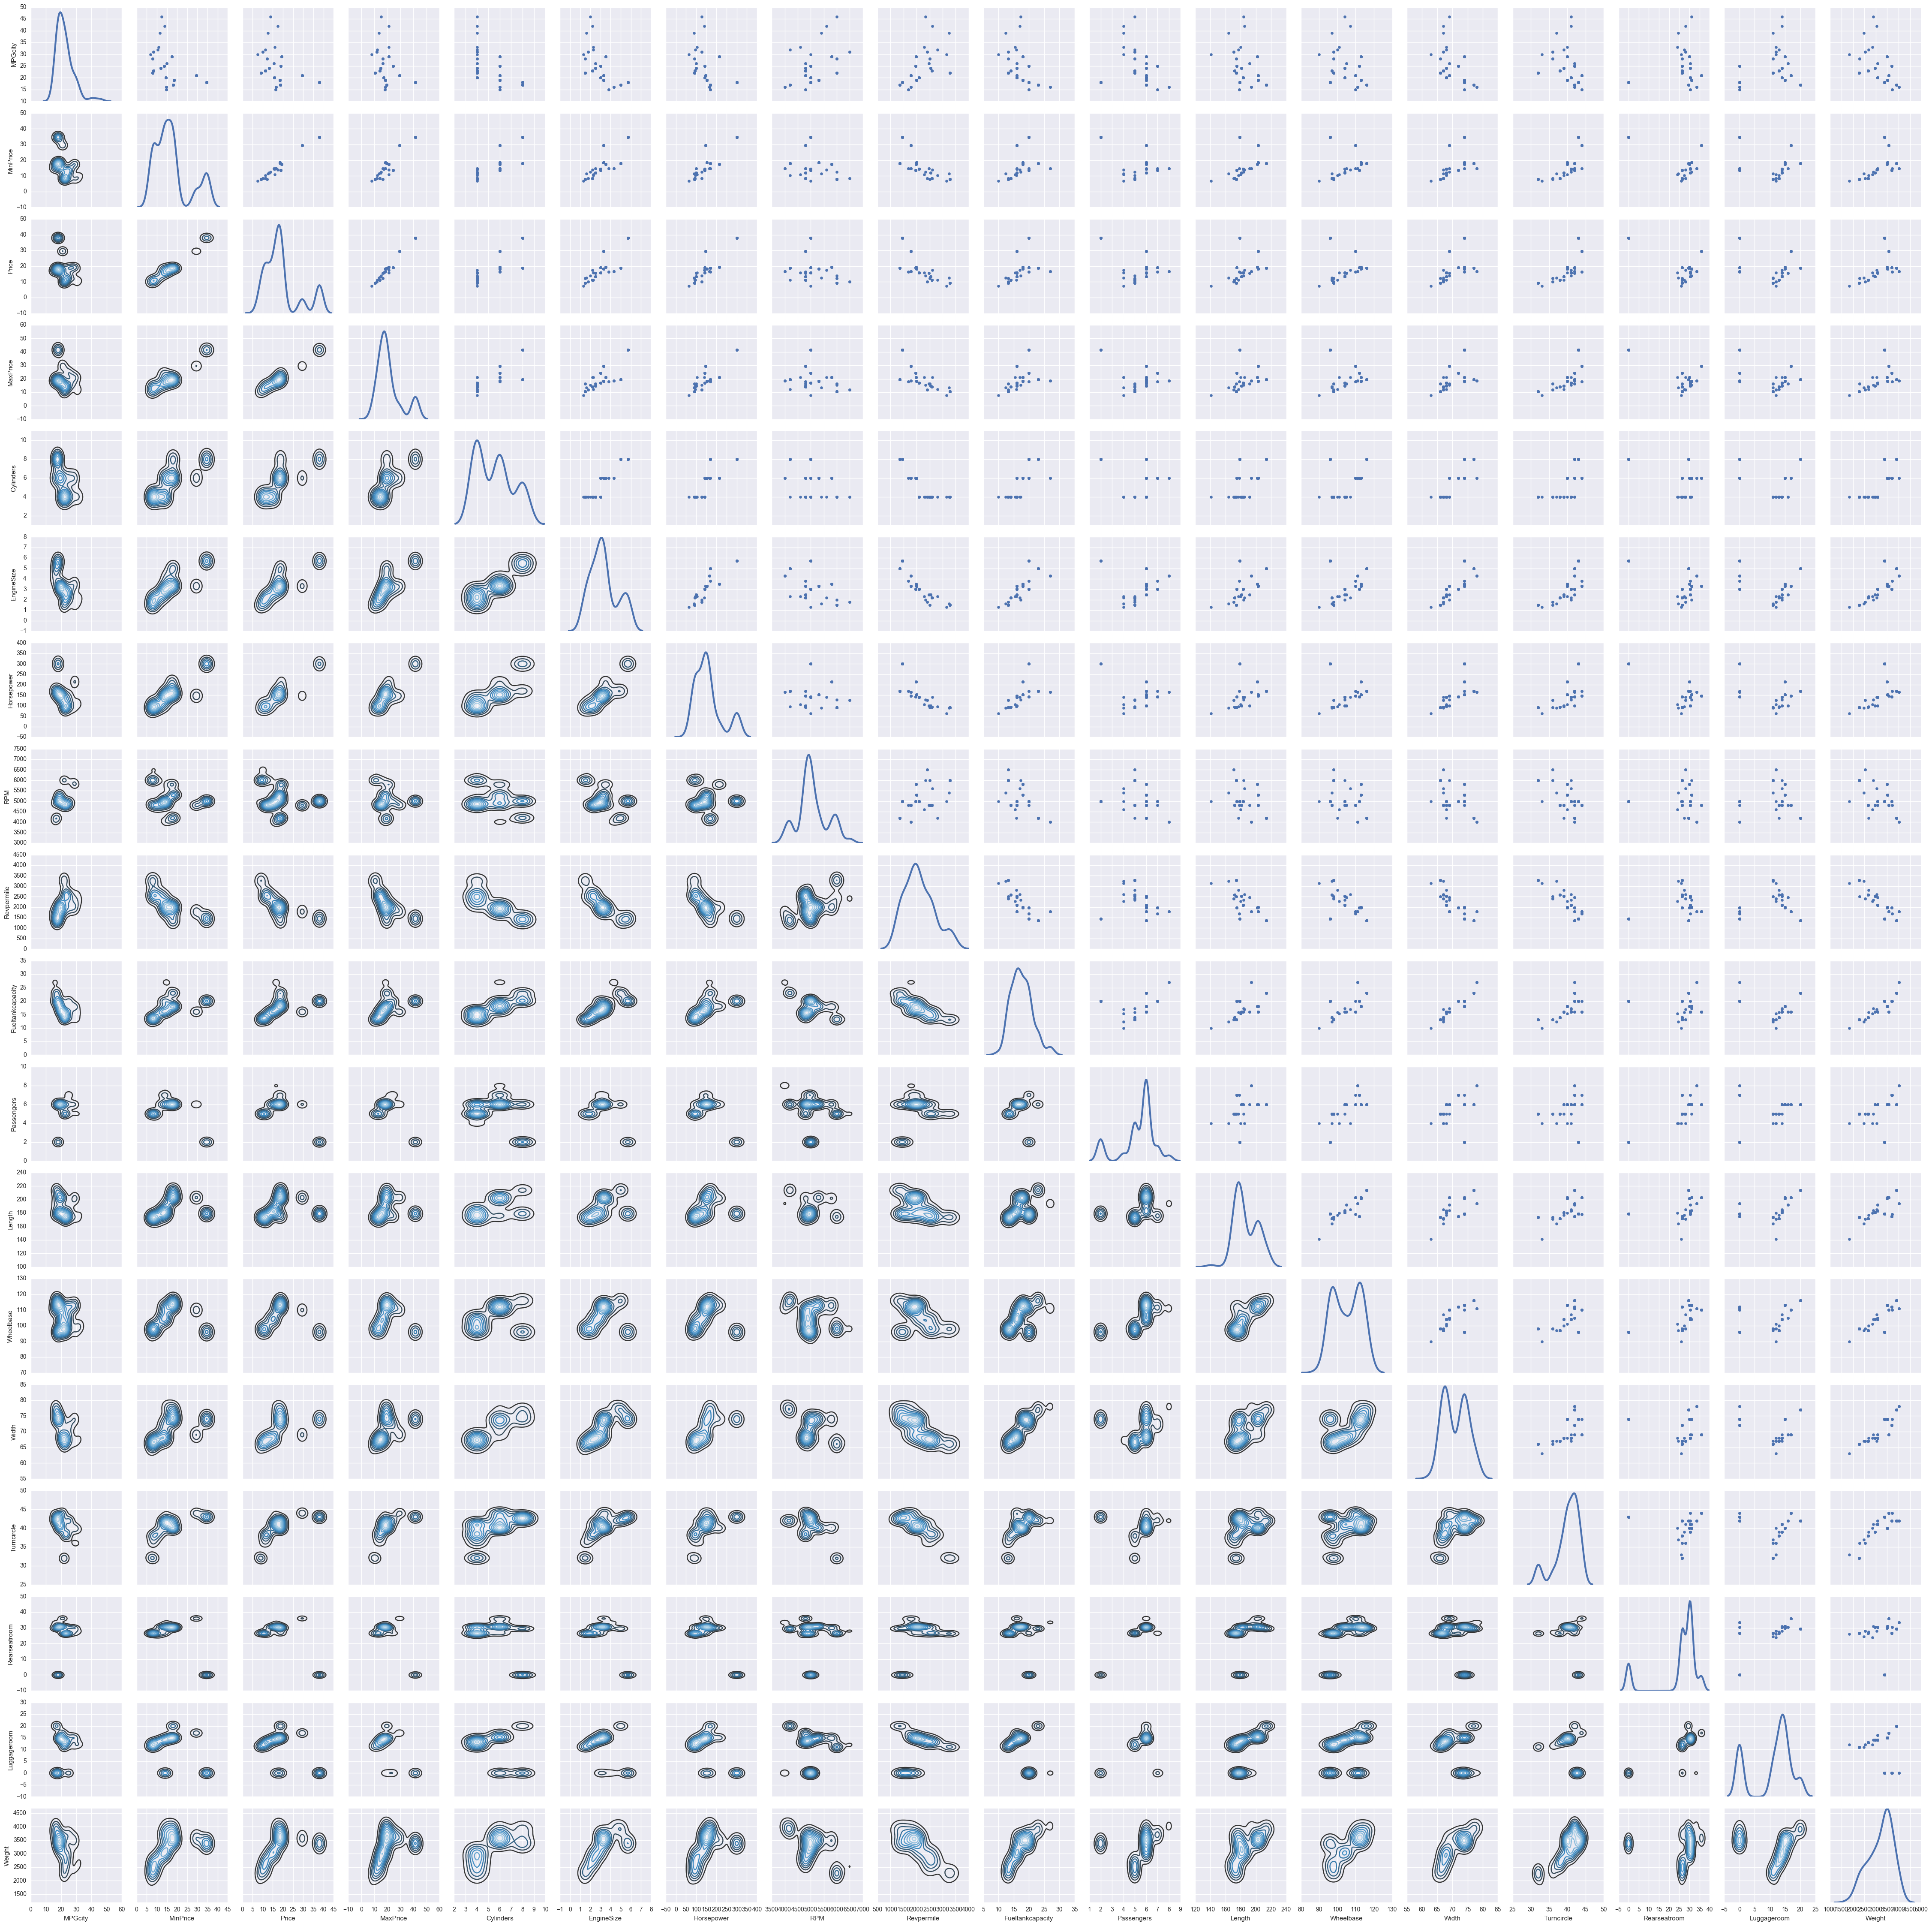

In [82]:
g = sns.PairGrid(data, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3);

That gives us something to work with, but there's no clear slam dunk. also, various features appear to have a curvilinear relation with MPG.

### F Values

The "F value'' statistics tests the overall significance of the regression model.  Specifically, it tests the null hypothesis that all of the regression coefficients are equal to zero.  This tests the full model against a model with no variables and with the estimate of the dependent variable being the mean of the values of the dependent variable.  The F value is the ratio of the mean regression sum of squares divided by the mean error sum of squares.  Its value will range from zero to an arbitrarily large number.

The null hypothesis is rejected if the F ratio is large. Some analysts recommend ignoring the P values for the individual regression coefficients if the overall F ratio is not statistically significant, because of the problems caused by multiple testing. Here we'll reject the features if they are smaller than 10.



In [83]:
# How many features don't meet the F test threshold?
sum(f_regression_feature_selection(X,y)[0] < 10)

2

In [84]:
# Which column are we talking about?
select = f_regression_feature_selection(X,y)[0] < 10
X.columns[select]

Index([u'Rearseatroom', u'Luggageroom'], dtype='object')

The two columns we replaced the missing values! At this point I'm more than happy to drop them.

In [85]:
# difference between the ones available and the ones we wish to drop
post_select = X.columns.difference(X.columns[select])

Xs = X[post_select]

In [86]:
Xs.head()

Cylinders  EngineSize  Fueltankcapacity  Horsepower  Length  MaxPrice  \
0          4         1.8              13.2         140     177      18.8   
1          6         3.2              18.0         200     195      38.7   
2          6         2.8              16.9         172     180      32.3   
3          6         2.8              21.1         172     193      44.6   
4          4         3.5              21.1         208     186      36.2   

   MinPrice  Passengers  Price   RPM  Revpermile  Turncircle  Weight  \
0      12.9           5   15.9  6300        2890          37    2705   
1      29.2           5   33.9  5500        2335          38    3560   
2      25.9           5   29.1  5500        2280          37    3375   
3      30.8           6   37.7  5500        2535          37    3405   
4      23.7           4   30.0  5700        2545          39    3640   

   Wheelbase  Width  
0        102     68  
1        115     71  
2        102     67  
3        106     70  
4        109     69

### P values

In [90]:
# How many features don't meet the F test threshold?
sum(f_regression_feature_selection(Xs,y)[1] < 0.05)

15

Great! All of our predictors are significant ( p < 0.05 ) in a univariate regression.

The homework asked to select featured based on their P value.

In [91]:
# Sort the features based on their statistical significance 
ps = f_regression_feature_selection(Xs,y)[1]

p_score = zip(Xs.columns, ps)
ranked_p = sorted(p_score, key=lambda x:x[1])
ranked_p

[('Weight', 2.9670483343731049e-26),
 ('Fueltankcapacity', 4.1773201363735199e-23),
 ('Width', 3.890182137748601e-16),
 ('EngineSize', 1.6059725847409604e-15),
 ('Revpermile', 9.7975074836453473e-15),
 ('Horsepower', 1.536839579052813e-13),
 ('Wheelbase', 2.8546686246273759e-13),
 ('Turncircle', 3.0910080602984028e-13),
 ('Length', 3.1426124845759859e-13),
 ('MinPrice', 2.6168348463105494e-11),
 ('Cylinders', 2.338226059717327e-10),
 ('Price', 3.3083016774761616e-10),
 ('MaxPrice', 1.3229113958756686e-08),
 ('Passengers', 3.2316226989500005e-05),
 ('RPM', 0.00034813012242378833)]

Now, we don't have the full toolkit yet to guard against overfitting - we'll introduce this in another lesson - but this is how you would loop through the various features and see the scores.

In [93]:
from sklearn.linear_model import Ridge

In [94]:
# Let's first build univariate models to see how well each individual features performs
scores = []
for feat, score in ranked_p:
    est = Ridge()
    X = [[x] for x in Xs[feat]]
    est.fit(X,y)
    scores.append(est.score(X,y))

In [95]:
# Drop of R^2 with strong to weakest features
cols = [k[0] for k in ranked_p]
pd.DataFrame(scores,index=cols).iplot(kind='bar')

The first 3 features seem to be reasonably powerful, after which the next 6 features are mediocre, and the remaining features aren't useful by themselves and will likely be dropped. 

In [136]:
# Now let's build models which cummatively look well combinations of features performs
scores = []
feats = []
for feat, score in ranked_p:
    est = Ridge()
    feats.append(feat)
    if len(feats) == 1:
        X = [[x] for x in Xs[feat]]
    else:
        X = Xs[feats]
    est.fit(X, y)
    scores.append(est.score(X,y))

In [ ]:
# pd.DataFrame(scores,index=.iplot()

In [137]:
# Now let's build models which cummatively look well combinations of features performs
from sklearn.cross_validation import cross_val_score

scores_cv = []
feats = []
for feat, score in ranked_p:
    est = Ridge()
    feats.append(feat)
    if len(feats) == 1:
        X = [[x] for x in Xs[feat]]
    else:
        X = Xs[feats]
    est.fit(X, y)
    scores_cv.append(cross_val_score(est,X,y).mean())

In [139]:
# Drop of R^2 with strong to weakest features
# Drop of R^2 with strong to weakest features
# cols = [k[0] for k in ranked_p]
df_cv = pd.DataFrame(scores,index=feats, columns=['regular'])
df_cv['cv'] = scores_cv

df_cv.iplot()

The first feature `Weight` is of course the most important, but the second and third features don't give us as much lift as we might have hoped for. This might have been due to the first three values being highly multicollinear. Let's inspect.

In [105]:
correlation = Xs[[x[0] for x in ranked_p]].corr()

In [113]:
correlation.apply(abs).iplot(kind='heatmap', colorscale='spectral')

Compare this with the correlation plot of the whole dataset, and indeed! Apart from price correlating with min- and max-price, these are some of the most highly correlated features.

So, based on the P values, the most important features are

In [114]:
p_features = [x[0] for x in ranked_p][:5]
p_features

['Weight', 'Fueltankcapacity', 'Width', 'EngineSize', 'Revpermile']

Based on the the following plot, the feature which provide the largest improvement in R^2 are features [0,3,5], just out of interest, let's also build and score a model with only those features. 

In [117]:
handpicked_features = [ranked_p[x][0] for x in [0,4,6]]
print handpicked_features

['Weight', 'Revpermile', 'Wheelbase']


In [141]:
est = Ridge()
X = Xs[handpicked_features]
# est.fit(X, y).score(X,y)

cross_val_score(est, X,y).mean()

0.64224775572257886

Even though the addition of these features was pivotal for the previous cummalative model, when just taken alone 

### Recursive feature elimination

We could have also decided to use [Recursive Feature Elimination](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and weights are assigned to each one of them. Then, features whose absolute weights are the smallest are pruned from the current set features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

Since the RFE used our _coefficient size_ as a determinant of importance, we need to make sure we **standardise the data first**! This way the mean is always close to zero, and the standard deviation is one. 

In [143]:
stand_Xs = (Xs - Xs.mean()) / Xs.std()

In [173]:
from sklearn.feature_selection import RFE

# Create the RFE object and rank each features
est = Ridge()
rfe = RFE(estimator=est, n_features_to_select=1, step=1)

rfe.fit(stand_Xs, y)
ranking = rfe.ranking_

scores = zip(Xs.columns, ranking)
scores = sorted(scores, key=lambda x:x[1])

In [168]:
pd.DataFrame(abs(len(ranking)-ranking), index=Xs.columns, columns=['feat']).sort_values('feat',ascending=False).iplot(kind='bar')

So, how did the automatic RFE do compared to our own more manual feature selection?

In [174]:
rfe_features = [x[0] for x in scores][:5]
print 'P Value:', p_features
print 'RFE Value:', rfe_features
print 'Handpicked Values:', handpicked_features

P Value: ['Weight', 'Fueltankcapacity', 'Width', 'EngineSize', 'Revpermile']
RFE Value: ['Weight', 'Fueltankcapacity', 'Wheelbase', 'Revpermile', 'EngineSize']
Handpicked Values: ['Weight', 'Revpermile', 'Wheelbase']


In [172]:
for feats in [handpicked_features, p_features, rfe_features]:
    est = Ridge()
    X = Xs[feats]
    print cross_val_score(est, X, y).mean()

0.642247755723
0.671181739716
0.594851599508


The RFE feature selection delivered the strongest model.

### Polynominal Features

In [175]:
from patsy import dmatrix

We will expand on polynominal feature selection once we introduce cross-validation, but for now let's use Ridge Regression to prevent against overfitting. Let's continue with the features found by the RFE.

In [176]:
rfe_features

['Weight', 'Fueltankcapacity', 'Wheelbase', 'Revpermile', 'EngineSize']

In [177]:
poly_features = []

In [178]:
[poly_features.append(dmatrix('C('+ str(feat) +', Poly)', Xs)) for feat in rfe_features];

In [179]:
poly_features

[DesignMatrix with shape (93, 81)
   Columns:
     ['Intercept',
      'C(Weight, Poly).Linear',
      'C(Weight, Poly).Quadratic',
      'C(Weight, Poly).Cubic',
      'C(Weight, Poly)^4',
      'C(Weight, Poly)^5',
      'C(Weight, Poly)^6',
      'C(Weight, Poly)^7',
      'C(Weight, Poly)^8',
      'C(Weight, Poly)^9',
      'C(Weight, Poly)^10',
      'C(Weight, Poly)^11',
      'C(Weight, Poly)^12',
      'C(Weight, Poly)^13',
      'C(Weight, Poly)^14',
      'C(Weight, Poly)^15',
      'C(Weight, Poly)^16',
      'C(Weight, Poly)^17',
      'C(Weight, Poly)^18',
      'C(Weight, Poly)^19',
      'C(Weight, Poly)^20',
      'C(Weight, Poly)^21',
      'C(Weight, Poly)^22',
      'C(Weight, Poly)^23',
      'C(Weight, Poly)^24',
      'C(Weight, Poly)^25',
      'C(Weight, Poly)^26',
      'C(Weight, Poly)^27',
      'C(Weight, Poly)^28',
      'C(Weight, Poly)^29',
      'C(Weight, Poly)^30',
      'C(Weight, Poly)^31',
      'C(Weight, Poly)^32',
      'C(Weight, Poly)^33',
   

Let's build a new dataframe which has all the polynomial columns

In [180]:
poly_featurs_123 = [poly[:, 1:4] for poly in poly_features]

In [181]:
p = poly_featurs_123

dfs = [pd.DataFrame(p[x]) for x in range(5)]
dfs = pd.concat(dfs, axis=1)

We need to rewrite the columns names since they got lost in the transformation

In [182]:
column_names = [name + '^' + str(e) for name in rfe_features for e in range(1,4)]
column_names

['Weight^1',
 'Weight^2',
 'Weight^3',
 'Fueltankcapacity^1',
 'Fueltankcapacity^2',
 'Fueltankcapacity^3',
 'Wheelbase^1',
 'Wheelbase^2',
 'Wheelbase^3',
 'Revpermile^1',
 'Revpermile^2',
 'Revpermile^3',
 'EngineSize^1',
 'EngineSize^2',
 'EngineSize^3']

In [183]:
dfs.columns = column_names

In [184]:
dfs

Weight^1  Weight^2      Weight^3  Fueltankcapacity^1  \
0  -7.603546e-02 -0.066067  1.289666e-01           -0.170123   
1   9.504432e-02 -0.033337 -1.293121e-01            0.066570   
2   4.752216e-02 -0.101525 -9.788115e-02            0.022190   
3   5.702659e-02 -0.091524 -1.116098e-01            0.229296   
4   1.140532e-01  0.006667 -1.083936e-01            0.229296   
5  -4.276995e-02 -0.105844  8.998686e-02           -0.007397   
6   6.653103e-02 -0.079705 -1.221488e-01            0.066570   
7   1.900886e-01  0.239417  2.729774e-01            0.258883   
8   7.603546e-02 -0.066067 -1.289666e-01            0.110950   
9   1.093010e-01 -0.004016 -1.158493e-01            0.066570   
10  1.568231e-01  0.123269  3.844809e-02            0.184917   
11 -1.188054e-01  0.017805  9.934305e-02           -0.110950   
12 -6.177881e-02 -0.085842  1.173112e-01           -0.066570   
13  3.326551e-02 -0.113117 -7.247059e-02           -0.081363   
14  2.376108e-02 -0.118572 -5.309371e-02            0.007397   
15  1.283098e-01  0.041443 -7.619180e-02            0.184917   
16  1.758320e-01  0.186912  1.578458e-01            0.273676   
17  1.520709e-01  0.108495  1.424692e-02            0.258883   
18  5.227438e-02 -0.096752 -1.051109e-01            0.184917   
19  8.553989e-02 -0.050611 -1.315315e-01            0.066570   
20  1.900886e-02 -0.120618 -4.287367e-02           -0.022190   
21  9.979654e-02 -0.024017 -1.262421e-01           -0.022190   
22 -1.615754e-01  0.138498 -6.484211e-02           -0.170123   
23 -8.553989e-02 -0.050611  1.315315e-01           -0.140537   
24 -9.504432e-03 -0.123345  2.170264e-02           -0.022190   
25  1.235576e-01  0.029397 -8.863128e-02            0.184917   
26  1.425665e-02 -0.122209 -3.238783e-02           -0.022190   
27  1.473187e-01  0.094176 -7.827834e-03            0.170123   
28 -1.520709e-01  0.108495 -1.424692e-02           -0.170123   
29  7.128324e-02 -0.073113 -1.260560e-01            0.066570   
..           ...       ...           ...                 ...   
63 -1.045488e-01 -0.014244  1.217766e-01           -0.170123   
64  9.504432e-03 -0.123345 -2.170264e-02           -0.036983   
65  1.853364e-01  0.221461  2.320308e-01            0.184917   
66  2.851330e-02 -0.116072 -6.298150e-02            0.096157   
67 -2.376108e-02 -0.118572  5.309371e-02           -0.110950   
68 -3.326551e-02 -0.113117  7.247059e-02            0.007397   
69  1.283098e-01  0.041443 -7.619180e-02            0.184917   
70  6.653103e-02 -0.079705 -1.221488e-01            0.066570   
71 -9.029211e-02 -0.042201  1.310531e-01           -0.036983   
72 -1.378143e-01  0.066900  4.586393e-02           -0.170123   
73 -9.979654e-02 -0.024017  1.262421e-01           -0.110950   
74  3.326551e-02 -0.113117 -7.247059e-02           -0.081363   
75  6.177881e-02 -0.085842 -1.173112e-01            0.007397   
76  7.603546e-02 -0.066067 -1.289666e-01            0.066570   
77 -6.653103e-02 -0.079705  1.221488e-01            0.066570   
78 -1.140532e-01  0.006667  1.083936e-01           -0.184917   
79 -1.758320e-01  0.186912 -1.578458e-01           -0.273676   
80 -1.188054e-01  0.017805  9.934305e-02           -0.036983   
81  1.900886e-02 -0.120618 -4.287367e-02           -0.036983   
82 -1.805842e-01  0.203959 -1.936758e-01           -0.244090   
83 -1.710798e-01  0.170319 -1.244745e-01           -0.214503   
84 -1.425665e-02 -0.122209  3.238783e-02           -0.036983   
85 -3.012258e-18 -0.124254  8.140587e-18            0.096157   
86  1.425665e-01  0.080311 -2.784263e-02            0.170123   
87 -1.663276e-01  0.154182 -9.349543e-02           -0.199710   
88  1.663276e-01  0.154182  9.349543e-02            0.229296   
89 -4.752216e-03 -0.124027  1.088454e-02            0.096157   
90 -5.702659e-02 -0.091524  1.116098e-01            0.096157   
91 -4.752216e-03 -0.124027  1.088454e-02           -0.051777   
92  3.801773e-02 -0.109708 -8.149453e-02            0.140537   

    Fueltankcapacity^2  Fueltankcapacit

Now, finally, let's build a model with our 5 features all with 3rd order polynomimials.

In [185]:
est = Ridge()
print "R^2 of %.02f based on %s features" % (est.fit(dfs, y).score(dfs,y), len(dfs.columns))

R^2 of 0.78 based on 15 features


The model didn't improve spectacularly, so until we are better equiped to evaluated our models, we ought to stick with the linear model.

#### PolynomialFeatures

Alternatively, you can use the `PolynomialFeatures` function from Scikit-Learn.

In [186]:
from sklearn.preprocessing import PolynomialFeatures

In [187]:
poly = PolynomialFeatures(3)
poly_Xs = poly.fit_transform(Xs)

How many features did we create?

In [188]:
len(poly_Xs) - len(Xs.columns)

78

Yep - close to 100 features. Just for kicks, how close to 1 could we push our R^2?

In [190]:
est = Ridge()
print "R^2 of %.02f based on %s features" % (est.fit(poly_Xs, y).score(poly_Xs,y), len(poly_Xs))

R^2 of 1.00 based on 93 features


Yep - perfect model - perfectly overfit that is! We'll see soon how to deal with this.